# NARPS: design optimalisation

In this notebook, we're developing an optimal experimental design for a mixed gambled task.

A few shortcomings:
- I haven't taken into account temporal autocorrelation or the possibility of drift (will try to add this the following days)

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import gamma
import scipy


%matplotlib inline

## Define hrf functions

In [63]:
def spm_Gpdf(s,h,l):
    s = np.array(s)
    res = (h-1)*np.log(s) + h*np.log(l) - l*s - np.log(gamma(h))
    return np.exp(res)

def canonical(resolution):
    # translated from spm_hrf
    p=[6,16,1,1,6,0,32]
    dt = resolution/16.
    s = np.array(xrange(int(p[6]/dt+1)))
    #HRF sampled at 0.1 s
    hrf = spm_Gpdf(s,p[0]/p[2],dt/p[2]) - spm_Gpdf(s,p[1]/p[3],dt/p[3])/p[4]
    hrf = hrf[[int(x) for x in np.array(xrange(int(p[6]/resolution+1)))*16.]]
    hrf = hrf/np.sum(hrf)
    # duration of the HRF
    durhrf = 32.0
    # length of the HRF parameters in resolution scale
    laghrf = int(np.ceil(durhrf/resolution))
    hrf = hrf[:laghrf]

    return {"basishrf":hrf,"laghrf":laghrf}

## Define class for the experiment

There are a few settings that can be changed in the functions:
- The total number of trials: 256
- The ITI: 6 seconds --> **note: we assume a fixed ITI, could (and maybe should) be jittered !**
- The resolution: 0.1 seconds
- The gains: range 10\$ - 40\$, by 2\$ (as Tom et al.)
- The losses: range 5\$ - 20\$, by 1\$ (as Tom et al.)

In [64]:
class experiment(object):
    def __init__(self,ntrials=256,ITI=6,resolution=0.1):
        self.ntrials = ntrials
        self.ITI = ITI
        self.resolution = resolution
        self.xaxis = np.arange(0,ntrials*ITI,resolution)
    
    def get_experiment(self):
        self.onsets = range(0,int(self.ntrials*self.ITI/self.resolution),int(self.ITI/self.resolution))
        self.gains = np.round(np.random.uniform(10,40,self.ntrials)/2)*2
        self.losses = np.round(np.random.uniform(4,20,self.ntrials))
        distance = self.gains-self.losses
        
        reg_task = np.zeros(int(self.ntrials*self.ITI/self.resolution))
        reg_task[self.onsets] = 1
        reg_task_c = np.convolve(reg_task,canonical(self.resolution)['basishrf'][:len(reg_task)])
        
        reg_gain = np.zeros(int(self.ntrials*self.ITI/self.resolution))
        reg_gain[self.onsets] = (self.gains-np.mean(self.gains))/np.std(self.gains)
        reg_gain_c = np.convolve(reg_gain,canonical(self.resolution)['basishrf'][:len(reg_gain)])
        
        reg_loss = np.zeros(int(self.ntrials*self.ITI/self.resolution))
        reg_loss[self.onsets] = (self.losses-np.mean(self.losses))/np.std(self.losses)
        reg_loss_c = np.convolve(reg_loss,canonical(self.resolution)['basishrf'][:len(reg_loss)])

        reg_dist = np.zeros(int(self.ntrials*self.ITI/self.resolution))
        reg_dist[self.onsets] = (distance-np.mean(distance))/np.std(distance)
        reg_dist_c = np.convolve(reg_dist,canonical(self.resolution)['basishrf'][:len(reg_dist)])
      
        self.design = np.array([reg_task,reg_gain,reg_loss,reg_dist])
        self.design_c = np.array([reg_task_c,reg_gain_c,reg_loss_c,reg_dist_c])
               
        return self

    def compute_efficiency(self,contrasts):
        
        C = contrasts
        
        XtX = np.dot(EXP.design_c,EXP.design_c.T)  
        invZ = scipy.linalg.inv(XtX)
        CMC = np.matrix(C)*np.matrix(invZ)*np.matrix(C.T)
        
        self.Aopt = float(len(C) / np.matrix.trace(CMC))
        
        return self


## Example of creating a random design

In [65]:
EXP = experiment()
EXP.get_experiment()

# print out gains and losses choice
print("Gains: %s"%(str(EXP.gains)))
print("Losses: %s"%(str(EXP.losses)))


Gains: [ 22.  38.  36.  28.  20.  18.  14.  34.  38.  26.  12.  12.  34.  18.  38.
  38.  34.  28.  32.  40.  26.  18.  36.  20.  16.  20.  38.  38.  36.  12.
  30.  26.  12.  38.  38.  10.  28.  22.  34.  20.  36.  32.  18.  24.  18.
  24.  14.  38.  12.  24.  30.  38.  10.  26.  26.  38.  16.  30.  10.  38.
  30.  16.  16.  32.  28.  28.  24.  30.  14.  40.  34.  22.  32.  38.  24.
  10.  28.  18.  16.  18.  12.  28.  24.  20.  30.  14.  24.  16.  12.  34.
  40.  24.  24.  12.  18.  30.  36.  16.  36.  22.  36.  36.  24.  38.  12.
  38.  38.  16.  20.  22.  20.  14.  30.  22.  22.  34.  40.  16.  12.  26.
  30.  36.  38.  30.  16.  40.  16.  14.  28.  36.  26.  12.  24.  34.  32.
  14.  26.  20.  14.  34.  24.  24.  26.  28.  22.  38.  18.  14.  26.  28.
  24.  32.  18.  20.  32.  28.  16.  30.  26.  36.  18.  32.  30.  28.  24.
  12.  14.  34.  28.  24.  16.  32.  32.  20.  14.  38.  38.  28.  24.  16.
  26.  28.  38.  26.  22.  32.  18.  22.  20.  14.  26.  32.  14.  32.  20.
  38.

/Users/Joke/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


#### This figure below shows the expected BOLD signal with the task.  If there would be a complete separability between gains and losses and the difference between both, the following plot shows the expected BOLD signal

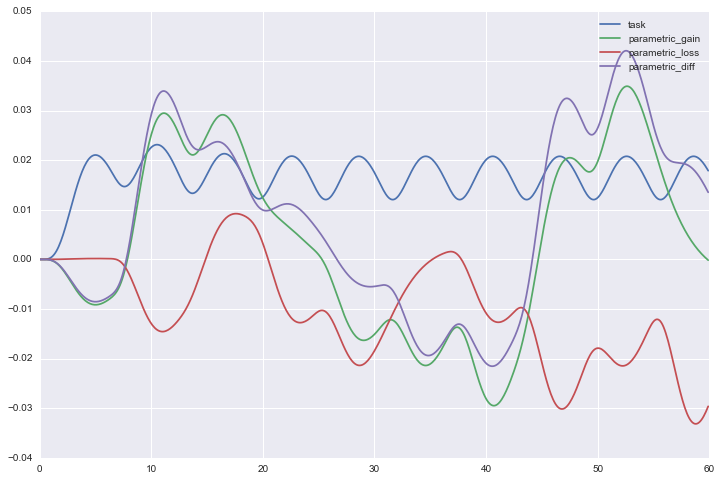

In [67]:
# generate figure
plt.figure(figsize=(12,8))
labs = ["task",'parametric_gain','parametric_loss','parametric_diff']
for x in range(4):
    plt.plot(EXP.xaxis[:600],EXP.design_c.T[:600,x],label=labs[x])
plt.legend()

### Contrasts
To compute the efficiency of the design, we also need to define the contrasts.  Here I defined a contrast of 
- main effect of task
- difference between loss and gain trials

Of course you can/should change as you please :-)

In [68]:
cons = np.array([
        [1,0,0,0],
        [0,1,-1,0]
    ])

EXP.compute_efficiency(cons)
print(EXP.Aopt)

4.24131004455e-16


## Generate random designs and optimise

In [69]:
allexp = []
for seed in range(100):
    EXP = experiment()
    EXP.get_experiment()
    cons = np.array([
            [1,0,0,0],
            [0,1,-1,0]
        ])
    EXP.compute_efficiency(cons)
    #print("Random experiment %i: efficiency %d"%(seed,EXP.Aopt))
    out = {"opt":EXP.Aopt,"gains":EXP.gains,"losses":EXP.losses,"experiment":EXP.design_c,"xaxis":EXP.xaxis}
    allexp.append(out)
    EXP = None


/Users/Joke/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


## Extract optimal design

Distribution of optimisation scores:

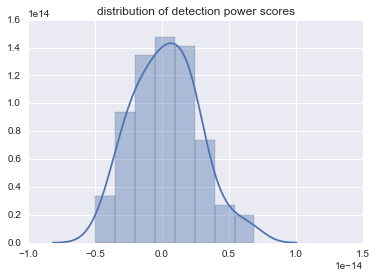

In [86]:
opt = [x['opt'] for x in allexp]

ax = plt.axes()
sns.distplot(opt,ax=ax)
ax.set_title("distribution of detection power scores")

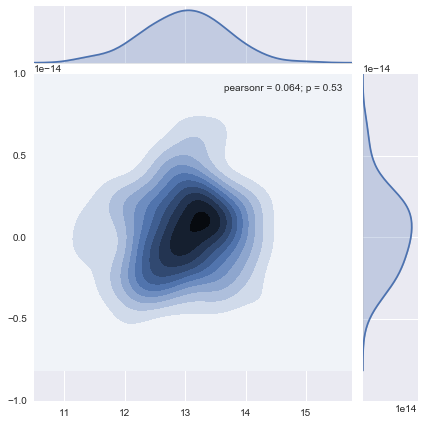

In [97]:
# making sure the difference between gain and loss does not affect optimality scores
ist = np.mean([x['gains']-x['losses'] for x in allexp],axis=1)
sns.jointplot(ist,np.array(opt),ylim=(-1e-14,1e-14),kind='kde')

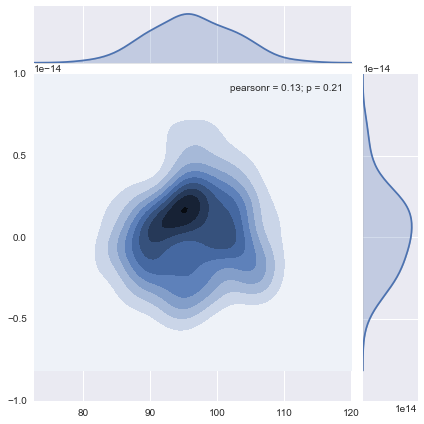

In [98]:
# making sure the variance on the difference between gain and loss does not affect optimality scores
ist = np.var([x['gains']-x['losses'] for x in allexp],axis=1)
sns.jointplot(ist,np.array(opt),ylim=(-1e-14,1e-14),kind='kde')

Optimal design:

In [99]:
optind = int(np.where(np.array(opt)==np.max(opt))[0])
optimum = allexp[optind]
print(optimum)

{'opt': 6.8968976379816885e-15, 'losses': array([ 14.,   5.,   6.,  16.,   7.,  14.,  20.,  19.,  15.,  12.,  17.,
         9.,   4.,  13.,   9.,   6.,  18.,   6.,  18.,  15.,  18.,  14.,
         8.,  13.,  17.,   5.,  19.,  20.,  17.,  17.,  11.,   8.,   5.,
         5.,  14.,  10.,  19.,  10.,  16.,   9.,   9.,   9.,   7.,  16.,
        16.,  15.,  10.,   6.,  15.,  12.,  13.,  18.,  15.,  11.,  19.,
        19.,  20.,  19.,  14.,  17.,  17.,  17.,  15.,  12.,  18.,  17.,
        12.,  13.,  17.,   5.,   6.,   9.,   9.,  10.,   5.,  10.,  16.,
        19.,  14.,  16.,   5.,  18.,  12.,   9.,   8.,  15.,   7.,  10.,
        16.,   6.,  12.,  20.,   6.,  20.,   6.,   4.,  19.,  18.,  14.,
         7.,  13.,   8.,  15.,  12.,  17.,   6.,   7.,  18.,  15.,  15.,
        13.,   6.,  18.,  11.,   7.,  19.,  10.,  19.,  16.,   9.,  19.,
        17.,  16.,  17.,  10.,   8.,   4.,   6.,   5.,   7.,   5.,  14.,
         5.,  12.,  11.,  13.,   8.,  12.,  12.,  11.,  11.,  19.,  11.,
        1

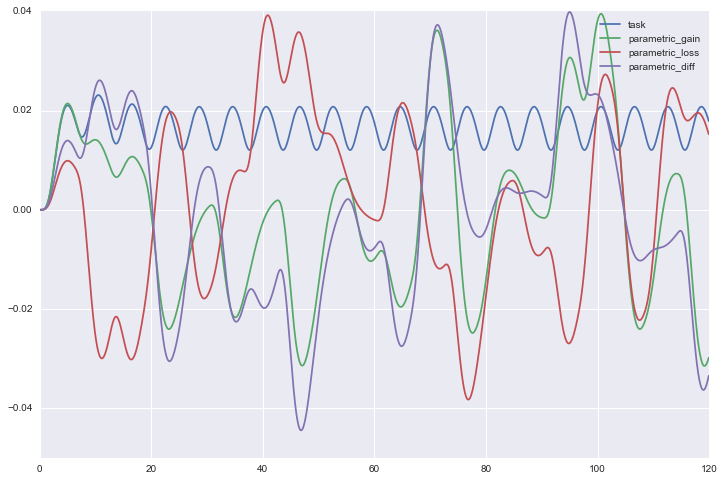

In [101]:
# generate figure
plt.figure(figsize=(12,8))
labs = ["task",'parametric_gain','parametric_loss','parametric_diff']
for x in range(4):
    plt.plot(optimum['xaxis'][:1200],optimum['experiment'].T[:1200,x],label=labs[x])

plt.legend()